In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'test', 'README']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'unsup',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'labeledBow.feat']

In [6]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [8]:
os.listdir(train_dir)

['urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'labeledBow.feat']

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [12]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f'Recenzja: {text_batch.numpy()[i]}')
    print(f'Etykieta: {label_batch.numpy()[i]}')

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [13]:
print(f'Etykieta 0 --> {raw_train_ds.class_names[0]}')
print(f'Etykieta 1 --> {raw_train_ds.class_names[1]}')

Etykieta 0 --> neg
Etykieta 1 --> pos


In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [17]:
#preprocessing danych -> normalizacja
#standardyzacja danych tekstowych
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]'%re.escape(string.punctuation),'')

In [18]:
#wektoryzacja tesktu
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [20]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [22]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [23]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0],label_batch[0]
print(f"Recenzja: {first_review}")
print(f"Etykieta: {first_label}")
print(f"Widok zwektoryzowany: {vectorize_text(first_review,first_label)}")

Recenzja: b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.'
Etykieta: 0
Widok zwektoryzowany: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 1199,
        1484,    4, 

In [29]:
print(f"17 --> {vectorize_layer.get_vocabulary()[17]}")
print(f"2 --> {vectorize_layer.get_vocabulary()[2]}")
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")
print(f"4916 --> {vectorize_layer.get_vocabulary()[4916]}")

17 --> movie
2 --> the
1287 --> silent
313 --> night
4916 --> unlikable


In [31]:
print(f'rozmiar słownika: {len(vectorize_layer.get_vocabulary())}')

rozmiar słownika: 10000


In [35]:
#przygotowanie wydajnościowe zbiorów

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
#Tworzenie modelu
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [38]:
model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [39]:
epochs=10
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6633 - binary_accuracy: 0.6963 - val_loss: 0.6152 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5494 - binary_accuracy: 0.8011 - val_loss: 0.4996 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4458 - binary_accuracy: 0.8457 - val_loss: 0.4210 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3788 - binary_accuracy: 0.8669 - val_loss: 0.3742 - val_binary_accuracy: 0.8626
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3362 - binary_accuracy: 0.8784 - val_loss: 0.3452 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3049 - binary_accuracy: 0.8895 - val_loss: 0.3261 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 5s 8m

In [40]:
loss,accuracy = model.evaluate(test_ds)

782/782 [==============================] - 5s 6ms/step - loss: 0.3106 - binary_accuracy: 0.8736


In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

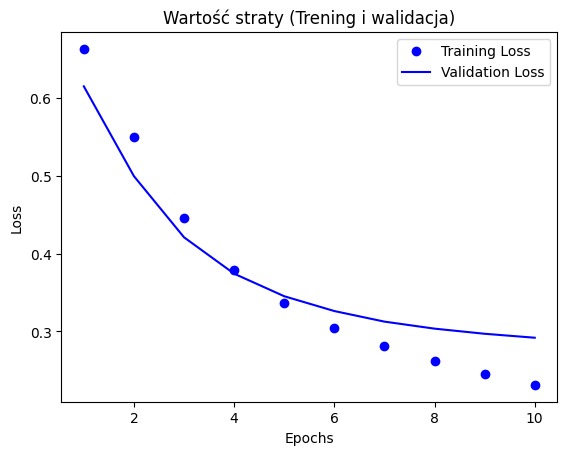

In [43]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')

plt.title('Wartość straty (Trening i walidacja)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

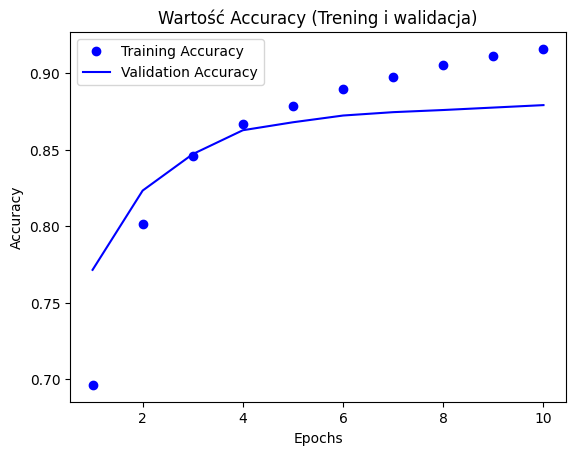

In [44]:
plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')

plt.title('Wartość Accuracy (Trening i walidacja)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3106 - accuracy: 0.8736
0.8736000061035156


In [53]:
testy = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible.",
    "Very bad movie!",
    "Big Shit!",
    "Disaster.",
    "Beautiful disaster",
    "Głupi film.",
    "The movie was bad bad bad bad bad bad",
    "The movie was okay okay okay okay okay okay okay okay.",
    "Great Great Great Great Great Great Great",
    "The movie was good with good acting but a poor screenplay."
]

In [54]:
export_model.predict(testy)

1/1 [==============================] - 0s 70ms/step


array([[0.6249697 ],
       [0.44850355],
       [0.3672014 ],
       [0.4217672 ],
       [0.5325821 ],
       [0.46706656],
       [0.56033015],
       [0.5273546 ],
       [0.03510018],
       [0.1346543 ],
       [0.9697    ],
       [0.34564877]], dtype=float32)